# Analysis of stem cell marker expressing cells

## Define cells expressing stem cell markers (Lgr5, Cd34, Gli1, Lgr6, Lrig1, Krt14)

In [329]:
seq = loadData_v1(path_input, exp_id, 'seq', 'DataFrame')

In [330]:
seq_ = dropNull(seq, path_input, cutoff_mean = 0.00)


Dropping spikes from dataset

Dropping repeats from dataset

Dropping unexpressed genes from dataset


In [331]:
NBR_2nd_summary = loadData_from_pickle_v1(path_output, exp_id,'NBR_2nd_summary')

## Binarize gene expression based on expression above Baseline (99.9% posterior probability) x factor 10. For Lrig1, use factor x 5.

In [332]:
#exclude if applicable SG and immune cells which express SC markers from analysis

ix_sel = s_groups_2nd[~s_groups_2nd.isin([14,23,24])].index

In [333]:
cells_Lgr5 = neg_binom_bin_cell_above_baseline(seq_[ix_sel], NBR_2nd_summary, ['Lgr5'], factor = 10.0)
cells_Cd34 = neg_binom_bin_cell_above_baseline(seq_[ix_sel], NBR_2nd_summary, ['Cd34'], factor = 10.0)
cells_Gli1 = neg_binom_bin_cell_above_baseline(seq_[ix_sel], NBR_2nd_summary, ['Gli1'], factor = 10.0)
cells_Lgr6 = neg_binom_bin_cell_above_baseline(seq_[ix_sel], NBR_2nd_summary, ['Lgr6'], factor = 10.0)
cells_Lrig1 = neg_binom_bin_cell_above_baseline(seq_[ix_sel], NBR_2nd_summary, ['Lrig1'], factor = 5.0)
cells_Krt14 = neg_binom_bin_cell_above_baseline(seq_[ix_sel], NBR_2nd_summary, ['Krt14'], factor = 10.0)

In [334]:
cells_SC = pd.DataFrame(0,index = ['Lgr5','Cd34','Gli1','Lgr6','Lrig1','Krt14'], columns = s_groups_1st.index)

cells_SC.ix['Lgr5', cells_Lgr5.ix['Lgr5'][cells_Lgr5.ix['Lgr5']==1].index] = 1
cells_SC.ix['Cd34', cells_Cd34.ix['Cd34'][cells_Cd34.ix['Cd34']==1].index] = 1
cells_SC.ix['Gli1', cells_Gli1.ix['Gli1'][cells_Gli1.ix['Gli1']==1].index] = 1
cells_SC.ix['Lgr6', cells_Lgr6.ix['Lgr6'][cells_Lgr6.ix['Lgr6']==1].index] = 1
cells_SC.ix['Lrig1', cells_Lrig1.ix['Lrig1'][cells_Lrig1.ix['Lrig1']==1].index] = 1
cells_SC.ix['Krt14', cells_Krt14.ix['Krt14'][cells_Krt14.ix['Krt14']==1].index] = 1

In [335]:
cells_SC.sum(axis = 1)

Lgr5     138
Cd34     297
Gli1      84
Lgr6      75
Lrig1    207
Krt14    149
dtype: int64

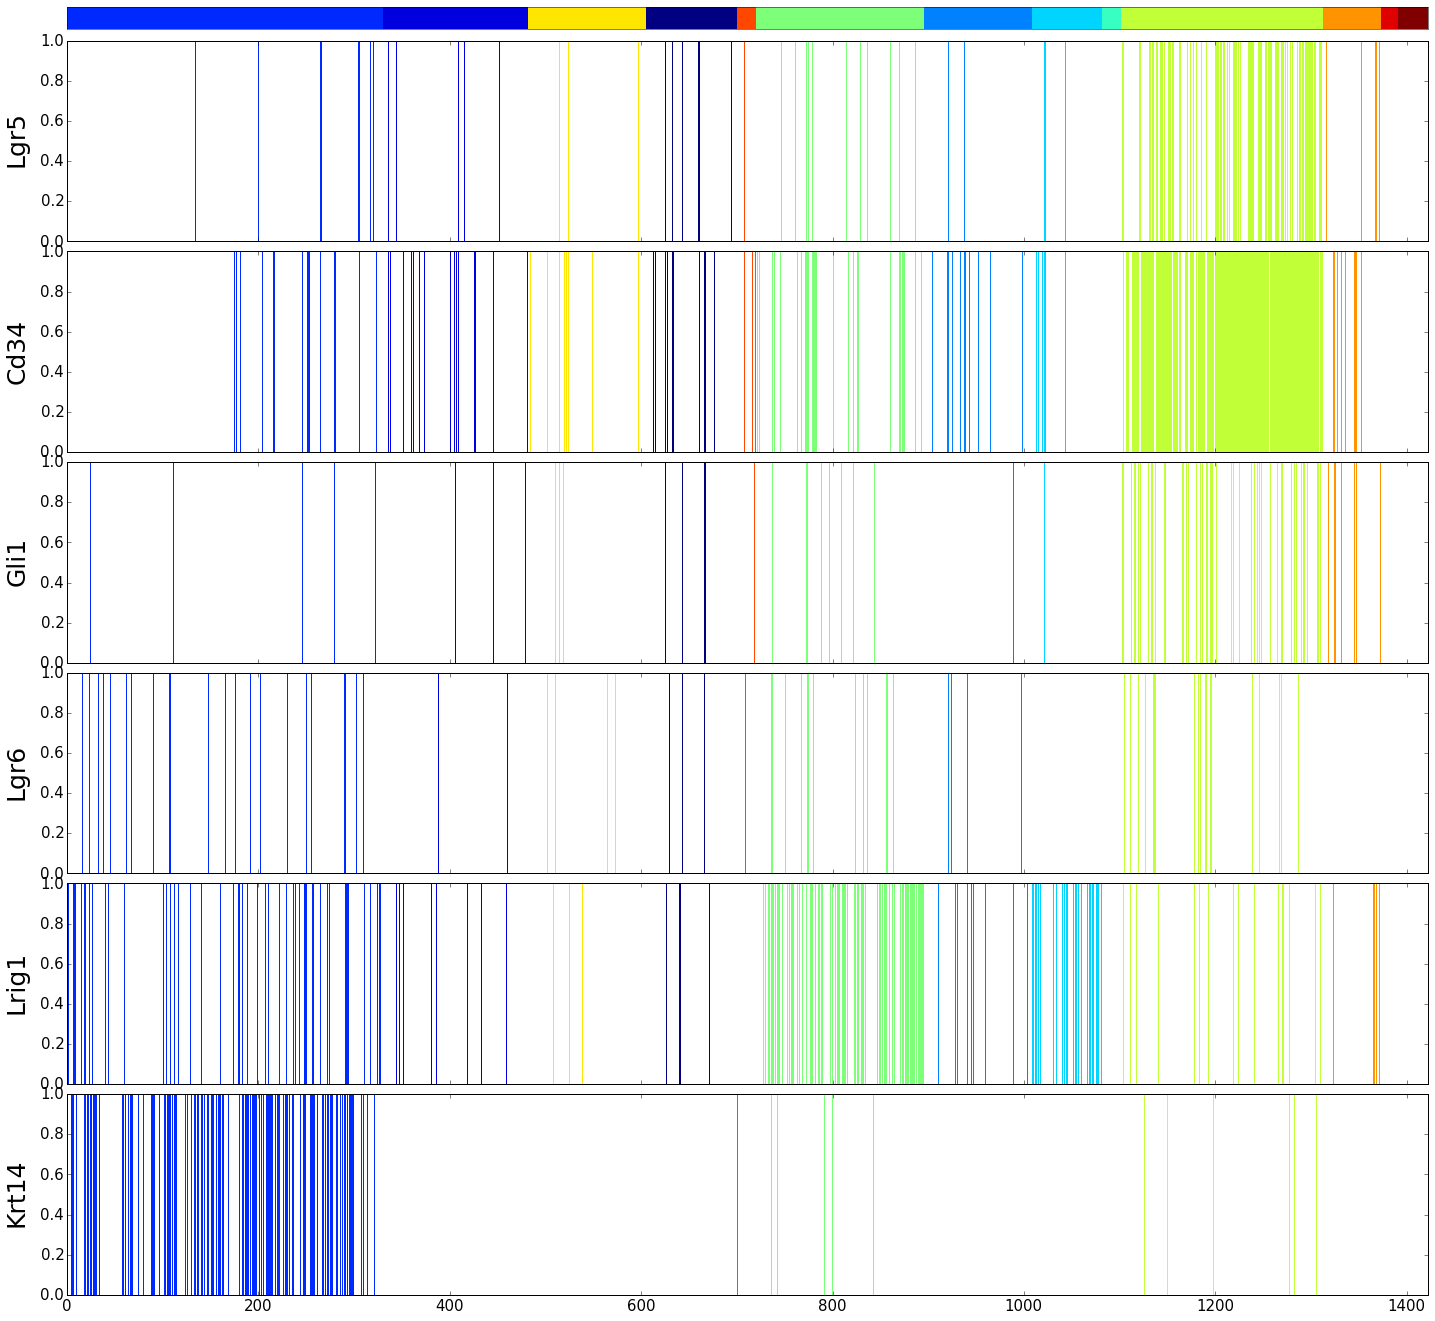

In [336]:
draw_barplots(cells_SC, s_groups_1st, ['Lgr5','Cd34','Gli1','Lgr6','Lrig1','Krt14'])

## Checkpoint

In [337]:
#saveData_v1(cells_SC, path_output, exp_id, 'cells_SC')

In [338]:
cells_SC = loadData_v1(path_output, exp_id, 'cells_SC', 'DataFrame')

# Cluster basal cells

In [889]:
s_groups_2nd = loadData_v1(path_output, exp_id, 's_groups_2nd', 'Series')

In [2201]:
PT_corr_max = loadData_v1(path_output, exp_id, 'PT_corr_max', 'Series')
PS_corr_max = loadData_v1(path_output, exp_id, 'PS_corr_max', 'Series')

## Select all non-SG keratinocytes with position <= 300. In contrast to pseudospatial ordering, use correlation data acquired after removing PS+PT-dependent genes and exclude non-basal IB cells.

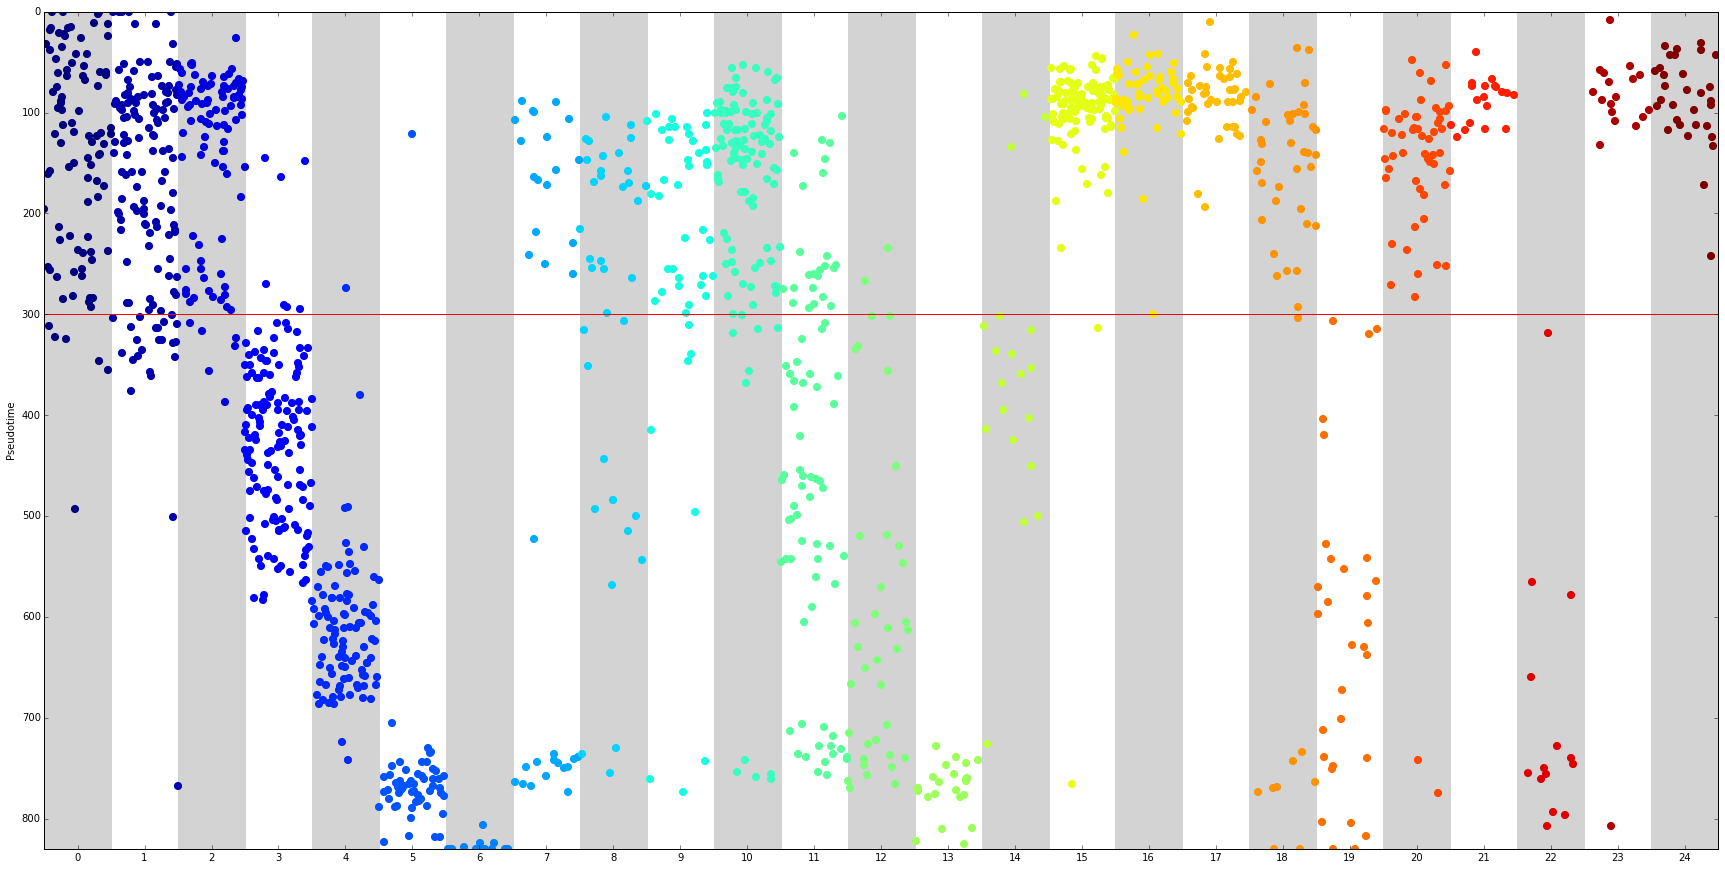

In [2203]:
data = PT_corr_max
cell_groups = s_groups_2nd
cmap = plt.cm.jet

#initialize figure

height = 15
width = 30

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define axis

ax = plt.subplot()

ax.set_ylim(np.max(data),0)
ax.set_ylabel('Pseudotime')

ax.set_xlim(-0.5, len(return_unique(cell_groups)) - 0.5)
ax.set_xticks(range(len(return_unique(cell_groups))))
ax.set_xticklabels(return_unique(cell_groups))

#plot data

for pos, gr in enumerate(return_unique(cell_groups)):
    
    cell_ix_tmp = cell_groups[cell_groups==gr].index
    
    ax.scatter([pos - 0.5 + np.random.random() for x in range(len(cell_ix_tmp))],
                [float(data[ix]) for ix in cell_ix_tmp],
                color = cmap(gr / float(np.max(cell_groups))),
                s = 50)
    
    #plot background
    
    if pos % 2 == 0:
        
        ax.axvspan(pos - 0.5, pos + 0.5, color = 'lightgrey', zorder = 0)
        
ax.axhline(300, 0, 1, color = 'red')

In [2204]:
cells_basal = s_groups_2nd[~s_groups_2nd.isin([7,8,9,14,20,22,23,24])].index
cells_basal = PT_corr_max[cells_basal][PT_corr_max[cells_basal]<=300].index

In [2205]:
len(cells_basal)

673

In [2206]:
Counter(s_groups_2nd.ix[cells_basal])

Counter({0: 88,
         1: 111,
         2: 88,
         3: 7,
         4: 1,
         5: 1,
         10: 100,
         11: 24,
         12: 2,
         15: 103,
         16: 51,
         17: 41,
         18: 37,
         21: 19})

## Select features


Dropping spikes from dataset

Dropping repeats from dataset

Dropping unexpressed genes from dataset

After mean expression cutoff of 0.1, 6887 genes remain

After correlation cutoff of 5, 6887 genes remain

Optimization terminated successfully.
         Current function value: 1310.992204
         Iterations: 24
         Function evaluations: 46

After high variance feature selection, 2500 genes remain

Calculating binary logarithm of x + 1


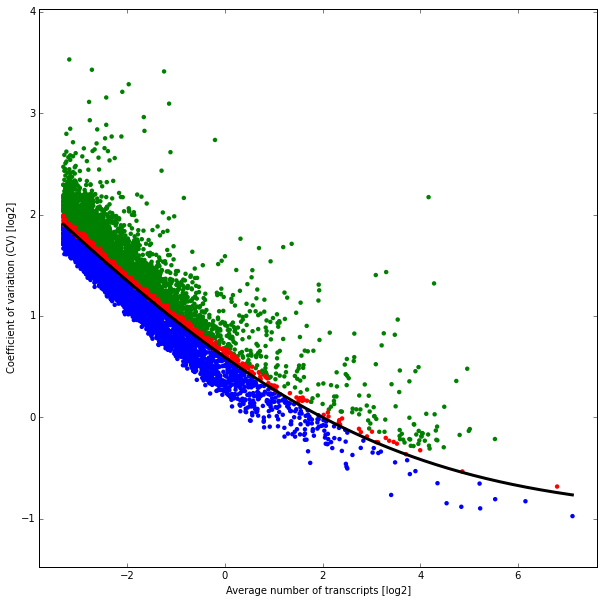

In [2207]:
seq_sel_basal = select_features_v1(seq[cells_basal], 0.10, 5, 2500, path_input)

# Remove genes which where identified as early immediate genes (#2) and housekeeping genes (#0) in the 1st lvl clustering

In [2208]:
genes_sel = list(set(seq_sel_basal.index.difference(g_groups_1st[g_groups_1st.isin([2,0])].index)))

seq_sel_basal = log2Transform(seq.ix[genes_sel, cells_basal])


Calculating binary logarithm of x + 1


In [2209]:
len(seq_sel_basal.index)

2235

## Checkpoint

In [2211]:
saveData_v1(seq_sel_basal, path_output, exp_id, 'seq_sel_basal')

In [2212]:
seq_sel_basal = loadData_v1(path_output, exp_id, 'seq_sel_basal', 'DataFrame')

## Cluster cells I

In [2213]:
preference = np.arange(-3.0, 0.0, 0.1)
damping = np.arange(0.5, 0.9, 0.05)

In [2215]:
affy_s_basal = seq_sel_basal.corr()
dist_s_basal = 1 - affy_s_basal

          -3.0      -2.9      -2.8      -2.7      -2.6      -2.5      -2.4  \
0.50 -628.5482 -628.5482 -629.1294 -629.1294 -628.5482 -629.1294 -628.5482   
0.55 -628.5482 -628.5482 -628.5482 -629.1294 -628.5482 -628.5482 -629.1294   
0.60 -629.1294 -629.1294 -628.5482 -628.5482 -628.5482 -629.1294 -629.1294   
0.65 -629.1294 -628.5482 -628.5482 -628.5482 -628.5482 -628.5482 -628.5482   
0.70 -628.5482 -628.5482 -628.5482 -628.5482 -628.5482 -628.5482 -628.5482   
0.75 -628.5482 -628.5482 -628.5482 -628.5482 -628.5482 -628.5482 -628.5482   
0.80 -629.1294 -629.1294 -629.1294 -629.1294 -629.1294 -629.1294 -629.1294   
0.85 -629.1294 -629.1294 -629.1294 -629.1294 -629.1294 -629.1294 -629.1294   

          -2.3      -2.2      -2.1    ...         -1.0      -0.9      -0.8  \
0.50 -628.5482 -628.5482 -628.5482    ...    -622.2118 -619.2466  -619.597   
0.55 -629.1294 -629.1294 -629.1294    ...     -618.045 -618.2264  -619.597   
0.60 -628.5482 -629.1294 -629.1294    ...     -619.597  -619.59

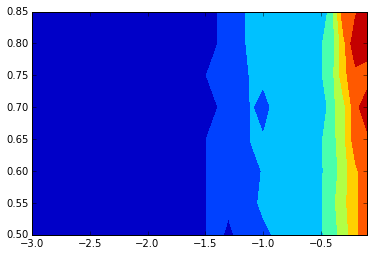

In [2216]:
IC_s, Ng_s = AP_IC_v3P(seq_sel_basal, affy_s_basal, 0, 'precomputed', preference, damping, path_scripts, dview, linkage='single', criterion='BIC')
print IC_s, Ng_s, plt.contourf(IC_s.columns, IC_s.index, IC_s)

In [2217]:
pref_s, damp_s = AP_IC_findmin(IC_s)
print pref_s, damp_s

-2.6 0.8


In [2218]:
s_groups_basal = AP_clustering_v3P(seq_sel_basal, affy_s_basal, 0, 'precomputed', pref_s, damp_s, path_scripts, linkage = 'single')

In [2219]:
len(set(s_groups_basal))

3

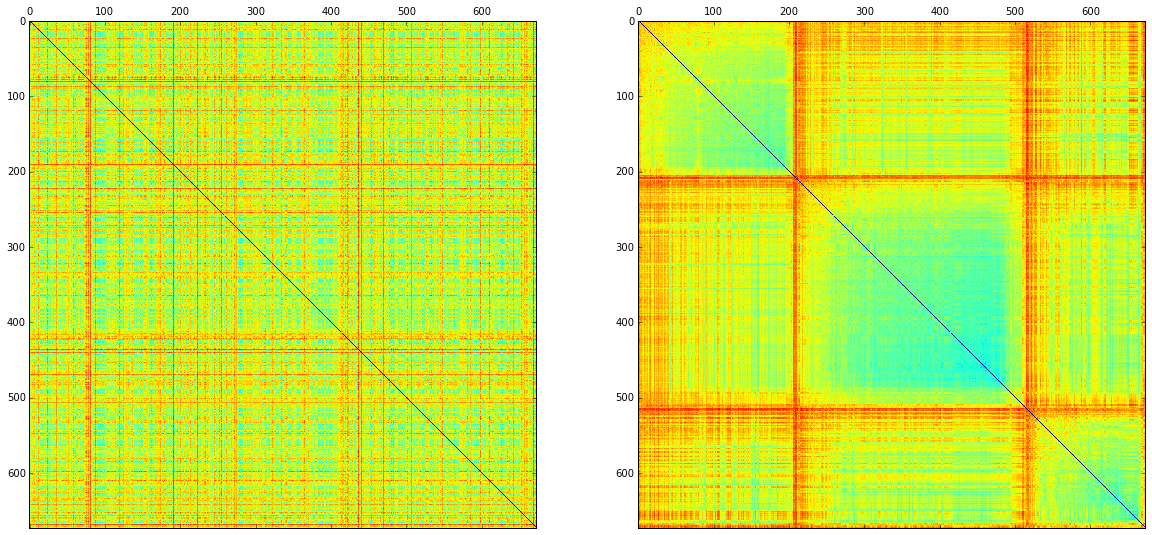

In [2220]:
draw_AP_dist_mat(dist_s_basal, s_groups_basal)

# Cluster genes I

In [2221]:
preference = np.arange(-5.0, -3.0, 0.1)
damping = np.arange(0.75, 0.9, 0.05)

In [2222]:
affy_g_basal = seq_sel_basal.T.corr()
dist_g_basal = 1 - affy_g_basal

          -5.0      -4.9      -4.8      -4.7      -4.6      -4.5      -4.4  \
0.75  -1257.82  -1257.82  -1257.82  -1257.82  -1257.82  -1257.82 -1260.173   
0.80 -1259.018 -1259.018 -1259.018 -1259.018 -1259.018 -1259.018 -1259.018   
0.85 -1259.018 -1259.018 -1259.018 -1259.018 -1259.018 -1259.018 -1259.018   
0.90 -1259.018 -1259.018 -1259.018 -1259.018 -1259.018 -1259.018 -1259.018   

          -4.3      -4.2      -4.1      -4.0      -3.9      -3.8      -3.7  \
0.75 -1258.916 -1259.038 -1253.651 -1253.651 -1253.651 -1253.651 -1253.651   
0.80 -1258.736 -1258.736 -1258.736 -1258.736 -1258.736 -1258.736 -1258.736   
0.85 -1258.736 -1258.736 -1258.736 -1258.736 -1258.736 -1258.736 -1258.736   
0.90 -1258.736 -1258.736 -1258.736 -1258.736 -1268.192 -1268.192 -1268.192   

          -3.6      -3.5      -3.4      -3.3      -3.2      -3.1  
0.75 -1269.252 -1266.033 -1317.542 -1321.249 -1321.524 -1321.524  
0.80 -1258.736 -1258.736 -1317.542 -1317.542 -1326.661 -1326.661  
0.85 -1258.736 -1

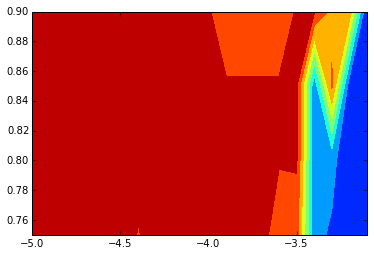

In [2223]:
IC_g, Ng_g = AP_IC_v3P(seq_sel_basal, affy_g_basal, 1, 'precomputed', preference, damping, path_scripts, dview, linkage='single', criterion='BIC')
print IC_g, Ng_g, plt.contourf(IC_g.columns, IC_g.index, IC_g)

In [2224]:
pref_g, damp_g = AP_IC_findmin(IC_g)
print pref_g, damp_g

-3.1 0.9


In [2225]:
g_groups_basal = AP_clustering_v3P(seq_sel_basal, affy_g_basal, 1, 'precomputed', pref_g, damp_g, path_scripts, linkage = 'single')

In [2226]:
len(set(g_groups_basal))

14

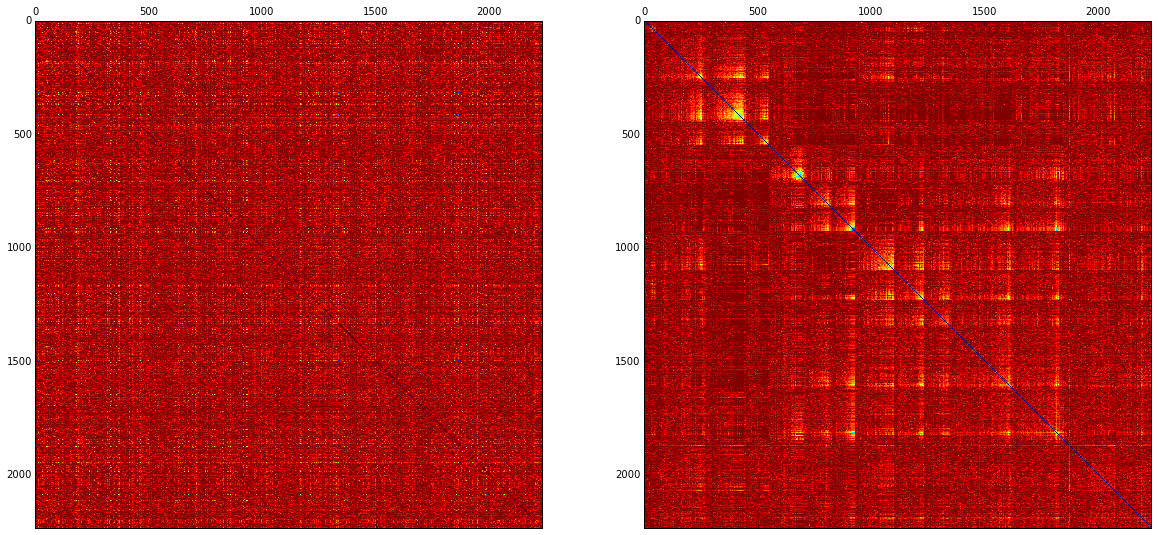

In [2227]:
draw_AP_dist_mat(dist_g_basal, g_groups_basal)

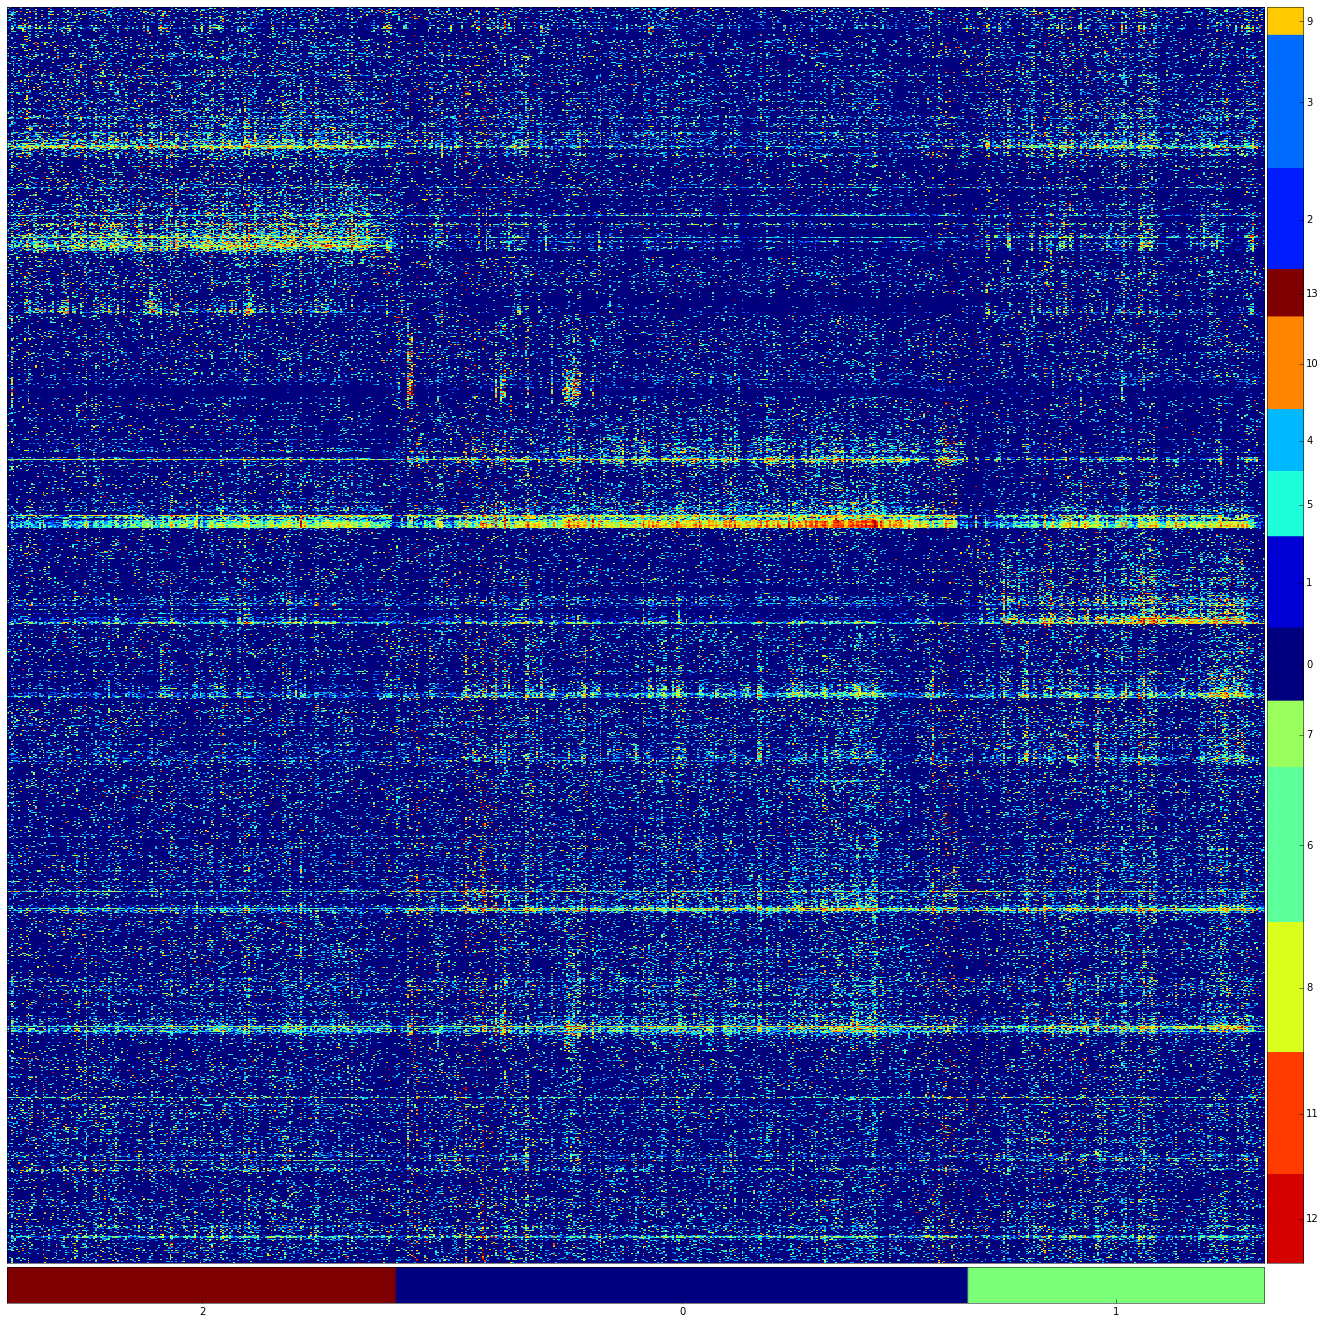

In [2228]:
draw_heatmap(seq_sel_basal, s_groups_basal, g_groups_basal)

In [2235]:
g_groups_basal[g_groups_basal==9]

Gene
Spef1            9
Slc35c2          9
Vegfb            9
Edem2            9
Tbc1d8           9
Brf1             9
Vps13d           9
Scyl1            9
Fam207a          9
Lgalsl           9
H2-Ab1           9
Csnk1e           9
Mid1             9
Sema4a           9
Vps39            9
Kcnq1ot1         9
Cry2             9
Fbxo33           9
2310003H01Rik    9
Ccny             9
Tmem55b          9
Mpdu1            9
Cbx4             9
Hs2st1           9
Wdsub1           9
Otud6b           9
Trex2            9
Scpep1           9
Pvrl3            9
Rmnd5a           9
2310002J15Rik    9
Bpifc            9
Elmod1           9
Csta             9
2310050C09Rik    9
Nccrp1           9
Kprp             9
Flg2             9
Crct1            9
Lce1m            9
Lor              9
Lce1l            9
Lce1b            9
Lce1a2           9
Lce1a1           9
Lce1c            9
Plk3             9
Btc              9
Prdm1            9
Gtf3c1           9
Nlrp10           9
dtype: int64

## Select groups #4 (IFE basal), #11, #1 (uHF) and #3, #2, 13 (outer bulge and pan-HF) as relevant spatial signatures for pseudospace ordering. Include #0 as early differentiation signature. Also include #10 (cell cycle)

In [2236]:
genes_sel = g_groups_basal[g_groups_basal.isin([4,11,1,3,2,13,0,10])].index

In [2237]:
seq_sel_basal_ = seq_sel_basal.ix[genes_sel]

In [2238]:
len(seq_sel_basal_.index)

1285

## Cluster cells II

In [2276]:
preference = np.arange(-3.0, -1.0, 0.1)
damping = np.arange(0.5, 0.95, 0.05)

In [2277]:
affy_s_basal = seq_sel_basal_.corr()
dist_s_basal = 1 - affy_s_basal

          -3.0      -2.9      -2.8      -2.7      -2.6      -2.5      -2.4  \
0.50 -649.0363  -647.256  -647.256 -642.6182  -647.256 -646.6548 -646.6548   
0.55 -647.2776 -647.2776 -646.9894 -646.6548 -646.6548 -646.6548 -646.9894   
0.60 -649.0363 -646.6548 -646.6548 -646.6548 -643.2963 -646.6548 -645.1966   
0.65 -647.2776 -646.6548 -645.1966 -645.1966  -647.256  -647.256  -647.256   
0.70  -647.256 -645.1966 -645.1966 -645.1966  -647.256 -645.1966 -645.1966   
0.75  -649.333 -648.9765  -647.256  -647.256 -648.4585 -648.4585  -647.256   
0.80 -648.4519 -648.4519 -648.4519 -648.4519 -643.7881 -643.7881 -643.7881   
0.85 -648.7928 -643.7881 -643.7881 -643.7881 -643.7881 -643.7881 -643.7881   
0.90 -643.7881 -643.7881 -643.7881 -643.7881 -643.7881 -643.7881 -643.7881   

          -2.3      -2.2      -2.1      -2.0      -1.9      -1.8      -1.7  \
0.50 -645.1966 -646.6548 -646.6548 -646.6548 -646.6548 -646.9894 -646.6548   
0.55 -646.9894 -646.6548 -646.6548 -646.6548 -646.6548 -646.654

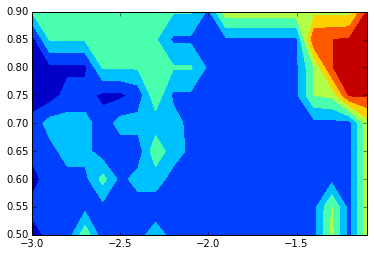

In [2278]:
IC_s, Ng_s = AP_IC_v3P(seq_sel_basal_, affy_s_basal, 0, 'precomputed', preference, damping, path_scripts, dview, linkage='single', criterion='BIC')
print IC_s, Ng_s, plt.contourf(IC_s.columns, IC_s.index, IC_s)

In [2279]:
pref_s, damp_s = AP_IC_findmin(IC_s)
print pref_s, damp_s

-3.0 0.75


In [2293]:
s_groups_basal = AP_clustering_v3P(seq_sel_basal_, affy_s_basal, 0, 'precomputed', -1.3, 0.5, path_scripts, linkage = 'single')

In [2294]:
len(set(s_groups_basal))

7

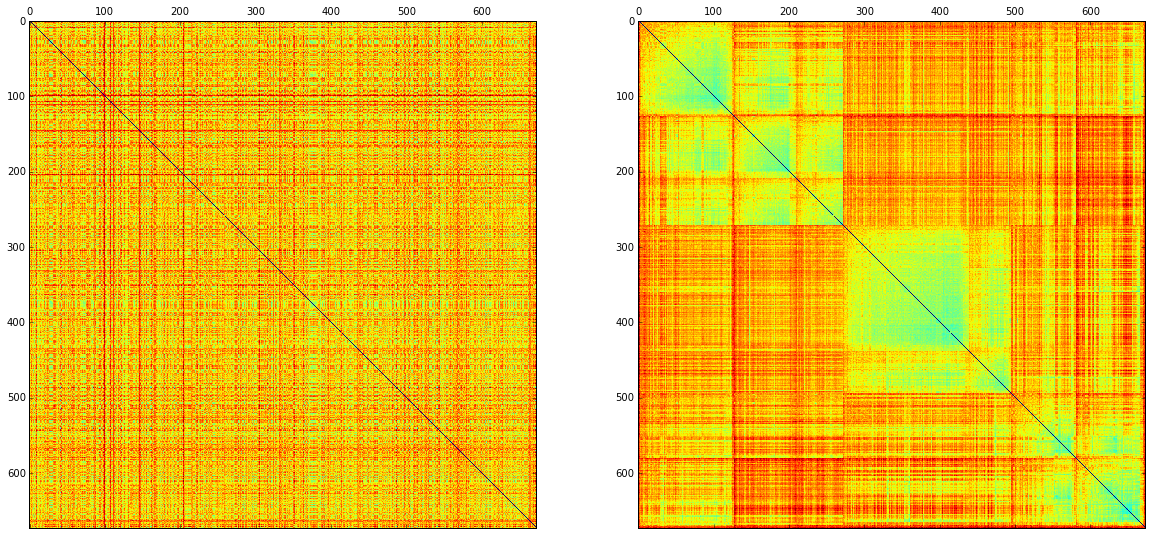

In [2295]:
draw_AP_dist_mat(dist_s_basal, s_groups_basal)

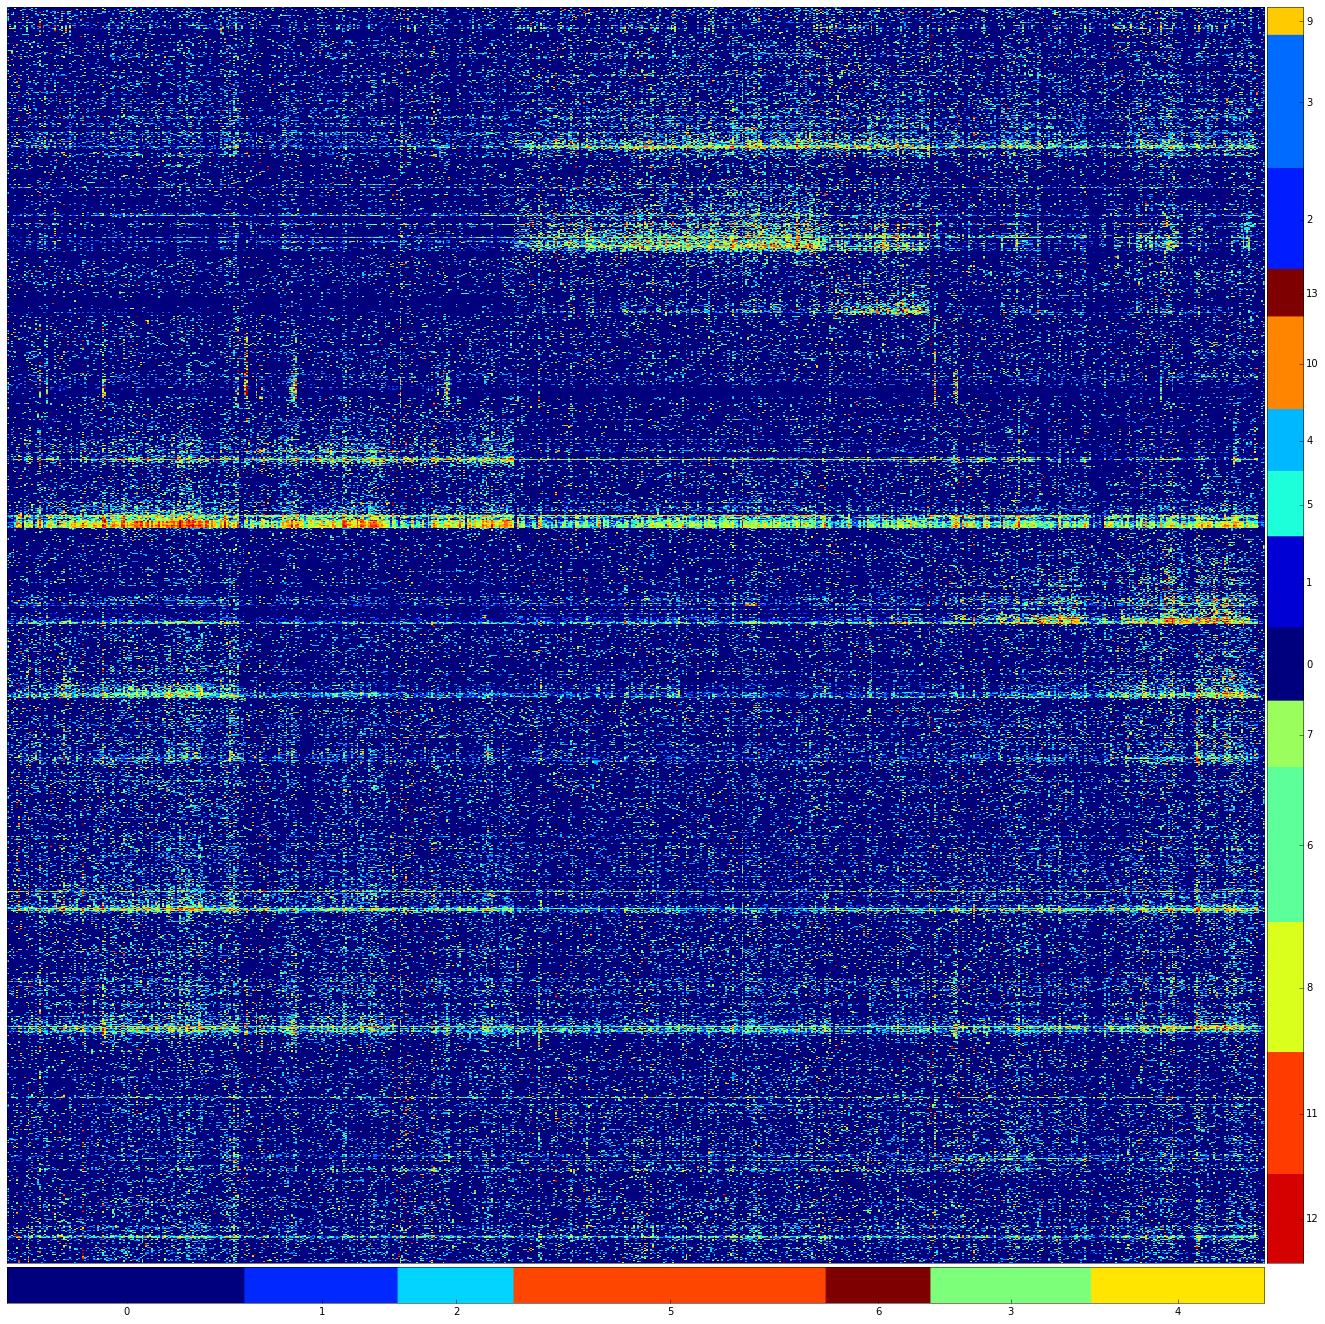

In [2296]:
draw_heatmap(seq_sel_basal, s_groups_basal, g_groups_basal)

## Include all non-basal cells in a group #7

In [2297]:
for ix in s_groups_1st.index:
    
    if ix not in s_groups_basal.index:
        
        s_groups_basal[ix] = 7

## Checkpoint

In [2299]:
saveData_v1(s_groups_basal, path_output, exp_id, 's_groups_basal')

In [2300]:
s_groups_basal = loadData_v1(path_output, exp_id, 's_groups_basal', 'Series')

## Find t-SNE representation of data

In [2301]:
dist_mat_tsne_basal = 1 - seq_sel_basal_.corr()

In [2356]:
"""
tsne_coords_basal = find_tSNE_v1P(dist_mat_tsne_basal, s_groups_basal, 60, dview, perplexity=20, early_exaggeration=2.0, learning_rate=1000.0,                             
                                        n_iter=1000, init='random', verbose=0, random_state=None)
"""

"\ntsne_coords_basal = find_tSNE_v1P(dist_mat_tsne_basal, s_groups_basal, 60, dview, perplexity=20, early_exaggeration=2.0, learning_rate=1000.0,                             \n                                        n_iter=1000, init='random', verbose=0, random_state=None)\n"

In [2479]:
tsne_basal = tsne_coords_basal[4]

## Checkpoint

In [2480]:
saveData_v1(tsne_basal, path_output, exp_id, 'tsne_basal')

# Perform negative binominal regression to mine for stem cell specific signatures

In [12]:
seq = loadData_v1(path_input, exp_id, 'seq', 'DataFrame')

In [13]:
seq_ = dropNull(seq, path_input, cutoff_mean = 0.00)


Dropping spikes from dataset

Dropping repeats from dataset

Dropping unexpressed genes from dataset


In [14]:
s_groups_basal = loadData_v1(path_output, exp_id, 's_groups_basal', 'Series')

## Define combined predictor matrix containing marker specific predictors, a pan-"SC predictor, pan-basal "SC" predictor and a pan-basal predictor.

In [15]:
cells_SC = loadData_v1(path_output, exp_id, 'cells_SC', 'DataFrame')

In [16]:
#define model
    
model = """
    data {
        int<lower=0> N; # number of outcomes
        int<lower=0> K; # number of predictors
        matrix<lower=0>[N,K] x; # predictor matrix
        int y[N]; # outcomes
    }

    parameters {
        vector<lower=1>[K] beta; # coefficients
        real<lower=0.001> r; # overdispersion
    }

    model {
        vector[N] mu;
        vector[N] rv; 
        
        # priors
        r ~ cauchy(0,1);
        beta ~ pareto(1,1.5);

        # vectorize the overdispersion
        for (n in 1:N) {
                rv[n] <- square(r + 1) - 1;
        }

        #regression
        mu <- x * (beta - 1) + 0.001;
        y ~ neg_binomial(mu ./ rv, 1 / rv[1]);
    }
    """

In [17]:
#number of outcomes
    
N = len(s_groups_basal.index)

In [18]:
print N

1422


In [19]:
#number of predictors
    
K = (1 + len(['Lgr5','Cd34','Gli1','Lgr6','Lrig1','Krt14','SC_all','SC_basal','all_basal','not_SC_basal']))

In [20]:
print K

11


In [21]:
#predictor matrix 
    
NxK = pd.DataFrame(index = ['Lgr5','Cd34','Gli1','Lgr6','Lrig1','Krt14','SC_all','SC_basal','all_basal','not_SC_basal'] + ['Baseline'], columns = s_groups_basal.index).fillna(0)

#0. Baseline

NxK.ix['Baseline'] = seq_[NxK.columns].sum(axis = 0) / seq_[NxK.columns].sum(axis = 0).mean()

#1. - 6. SC marker-specific predictors

for g in ['Lgr5','Cd34','Gli1','Lgr6','Lrig1','Krt14']:
    
    ix_tmp = cells_SC.ix[g][cells_SC.ix[g]==1].index
    
    NxK.ix[g, ix_tmp] = 1
    
#7. pan-SC marker predictor
    
ix_tmp = cells_SC.sum()[cells_SC.sum()>0].index

NxK.ix['SC_all', ix_tmp] = 1

#8. basal "SC" predictor

ix_tmp = [c for c in cells_SC.sum()[cells_SC.sum()>0].index if s_groups_basal[c] != 7]

NxK.ix['SC_basal', ix_tmp] = 1

#9. basal cell predictor

ix_tmp = s_groups_basal[s_groups_basal != 7].index

NxK.ix['all_basal', ix_tmp] = 1

#10. not SC basal cell predictor

ix_tmp = [c for c in s_groups_basal[s_groups_basal != 7].index if cells_SC[c].sum() == 0]

NxK.ix['not_SC_basal', ix_tmp] = 1

In [22]:
NxK.sum(axis = 1)

Lgr5             138
Cd34             297
Gli1              84
Lgr6              75
Lrig1            207
Krt14            149
SC_all           656
SC_basal         491
all_basal        673
not_SC_basal     182
Baseline        1422
dtype: float64

## For comparability, select the same genes used for NBR_2nd

In [23]:
NBR_2nd_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_2nd_traces')

In [24]:
genes_sel = NBR_2nd_traces.index

In [25]:
len(genes_sel)

9784

## Run model with SC_all predictor

In [ ]:
"""
NBR_SC_SC_all = neg_binom_regression_free_input_v2P(model, 
                                                    seq_,
                                                    genes_sel,
                                                    N, 
                                                    8, 
                                                    NxK.ix[['Lgr5','Cd34','Gli1','Lgr6','Lrig1','Krt14','SC_all','Baseline']], 
                                                    path_output, 
                                                    exp_id, 
                                                    'NBR_SC_SC_all', 
                                                    5000, 
                                                    dview, 
                                                    iter=275, 
                                                    chains=4, 
                                                    warmup=25, 
                                                    n_jobs=4)
"""

## Run model with SC_basal predictor

In [26]:
"""
NBR_SC_SC_basal_traces = neg_binom_regression_free_input_v2P(model, 
                                                    seq_,
                                                    genes_sel,
                                                    N, 
                                                    9, 
                                                    NxK.ix[['Lgr5','Cd34','Gli1','Lgr6','Lrig1','Krt14','SC_basal','not_SC_basal','Baseline']], 
                                                    path_output, 
                                                    exp_id, 
                                                    'NBR_SC_SC_basal_traces', 
                                                    10000, 
                                                    dview, 
                                                    iter=275, 
                                                    chains=4, 
                                                    warmup=25, 
                                                    n_jobs=4)
"""

2500 / 9784
9784 / 9784


## Run model with all_basal predictor

In [2492]:
"""
NBR_SC_all_basal_traces = neg_binom_regression_free_input_v2P(model, 
                                                    seq_,
                                                    genes_sel,
                                                    N, 
                                                    8, 
                                                    NxK.ix[['Lgr5','Cd34','Gli1','Lgr6','Lrig1','Krt14','all_basal','Baseline']], 
                                                    path_output, 
                                                    exp_id, 
                                                    'NBR_SC_all_basal_traces', 
                                                    10000, 
                                                    dview, 
                                                    iter=275, 
                                                    chains=4, 
                                                    warmup=25, 
                                                    n_jobs=4)
"""

0 / 9784
9784 / 9784


In [42]:
NBR_SC_SC_basal_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_SC_SC_basal_traces')
NBR_SC_SC_basal_summary = neg_binom_summary_stats_v1P(NBR_SC_SC_basal_traces, dview)
NBR_SC_SC_basal_bin_bl, NBR_SC_SC_basal_size_bl = neg_binom_vs_baseline_v1P(NBR_SC_SC_basal_summary, dview, PP='95')
NBR_SC_SC_basal_bin_gr, NBR_SC_SC_basal_size_gr = neg_binom_vs_groups_v1P(NBR_SC_SC_basal_summary, dview, PP='95')

In [2500]:
NBR_SC_all_basal_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_SC_all_basal_traces')
NBR_SC_all_basal_summary = neg_binom_summary_stats_v1P(NBR_SC_all_basal_traces, dview)
NBR_SC_all_basal_bin_bl, NBR_SC_all_basal_size_bl = neg_binom_vs_baseline_v1P(NBR_SC_all_basal_summary, dview, PP='95')
NBR_SC_all_basal_bin_gr, NBR_SC_all_basal_size_gr = neg_binom_vs_groups_v1P(NBR_SC_all_basal_summary, dview, PP='95')

In [44]:
saveData_to_pickle_v1(NBR_SC_SC_basal_summary, path_output, exp_id, 'NBR_SC_SC_basal_summary')
saveData_to_pickle_v1(NBR_SC_SC_basal_bin_bl, path_output, exp_id, 'NBR_SC_SC_basal_bin_bl')
saveData_to_pickle_v1(NBR_SC_SC_basal_size_bl, path_output, exp_id, 'NBR_SC_SC_basal_size_bl')
saveData_to_pickle_v1(NBR_SC_SC_basal_bin_gr, path_output, exp_id, 'NBR_SC_SC_basal_bin_gr')
saveData_to_pickle_v1(NBR_SC_SC_basal_size_gr, path_output, exp_id, 'NBR_SC_SC_basal_size_gr')

In [2502]:
#saveData_to_pickle_v1(NBR_SC_all_basal_summary, path_output, exp_id, 'NBR_SC_all_basal_summary')
#saveData_to_pickle_v1(NBR_SC_all_basal_bin_bl, path_output, exp_id, 'NBR_SC_all_basal_bin_bl')
#saveData_to_pickle_v1(NBR_SC_all_basal_size_bl, path_output, exp_id, 'NBR_SC_all_basal_size_bl')
#saveData_to_pickle_v1(NBR_SC_all_basal_bin_gr, path_output, exp_id, 'NBR_SC_all_basal_bin_gr')
#saveData_to_pickle_v1(NBR_SC_all_basal_size_gr, path_output, exp_id, 'NBR_SC_all_basal_size_gr')

# Use negative binominal regression to model SCM+ and SCM- basal signatures on top of compartments signatures

In [12]:
seq = loadData_v1(path_input, exp_id, 'seq', 'DataFrame')

In [13]:
seq_ = dropNull(seq, path_input, cutoff_mean = 0.00)


Dropping spikes from dataset

Dropping repeats from dataset

Dropping unexpressed genes from dataset


In [14]:
s_groups_2nd = loadData_v1(path_output, exp_id, 's_groups_2nd', 'Series')

In [15]:
s_groups_basal = loadData_v1(path_output, exp_id, 's_groups_basal', 'Series')

In [16]:
cells_SC = loadData_v1(path_output, exp_id, 'cells_SC', 'DataFrame')

## Define predictor matrix containing compartment specific predictors (IFE, uHF, uOB, OB) and SCM+ / SCM- basal predictors

In [17]:
#define model
    
model = """
    data {
        int<lower=0> N; # number of outcomes
        int<lower=0> K; # number of predictors
        matrix<lower=0>[N,K] x; # predictor matrix
        int y[N]; # outcomes
    }

    parameters {
        vector<lower=1>[K] beta; # coefficients
        real<lower=0.001> r; # overdispersion
    }

    model {
        vector[N] mu;
        vector[N] rv; 
        
        # priors
        r ~ cauchy(0,1);
        beta ~ pareto(1,1.5);

        # vectorize the overdispersion
        for (n in 1:N) {
                rv[n] <- square(r + 1) - 1;
        }

        #regression
        mu <- x * (beta - 1) + 0.001;
        y ~ neg_binomial(mu ./ rv, 1 / rv[1]);
    }
    """

In [18]:
#number of outcomes
    
N = len(s_groups_basal.index)

In [19]:
print N

1422


In [20]:
#number of predictors
    
K = len(['IFE','uHF','uOB','OB','SCMpos','SCMneg','Baseline'])

In [21]:
print K

7


In [31]:
#predictor matrix 
    
NxK = pd.DataFrame(index = ['IFE','uHF','uOB','OB','SCMpos','SCMneg','Baseline'], columns = s_groups_basal.index).fillna(0)

#0. Baseline

NxK.ix['Baseline'] = seq_[NxK.columns].sum(axis = 0) / seq_[NxK.columns].sum(axis = 0).mean()

#1. IFE signature

ix_tmp = [c for c in s_groups_basal[s_groups_basal != 7].index if s_groups_2nd[c] in [0,1,2,3,4,5,6]]
NxK.ix['IFE', ix_tmp] = 1

#2. uHF signature

ix_tmp = [c for c in s_groups_basal[s_groups_basal != 7].index if s_groups_2nd[c] in [7,8,9,10,11,12,13,18]]
NxK.ix['uHF', ix_tmp] = 1

#3. uOB signature

ix_tmp = [c for c in s_groups_basal[s_groups_basal != 7].index if s_groups_2nd[c] in [17]]
NxK.ix['uOB', ix_tmp] = 1

#4. OB signature

ix_tmp = [c for c in s_groups_basal[s_groups_basal != 7].index if s_groups_2nd[c] in [15,16,19,20,21,22]]
NxK.ix['OB', ix_tmp] = 1

#5. SCMpos signature

ix_tmp = [c for c in cells_SC.sum()[cells_SC.sum()>0].index if s_groups_basal[c] != 7]
NxK.ix['SCMpos', ix_tmp] = 1

#6. SCMneg signature

ix_tmp = [c for c in s_groups_basal[s_groups_basal != 7].index if cells_SC[c].sum() == 0]
NxK.ix['SCMneg', ix_tmp] = 1

In [32]:
NxK.sum(axis = 1)

IFE          296
uHF          163
uOB           41
OB           173
SCMpos       491
SCMneg       182
Baseline    1422
dtype: float64

## For comparability, select the same genes used for NBR_2nd

In [24]:
NBR_2nd_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_2nd_traces')

In [25]:
genes_sel = NBR_2nd_traces.index

In [26]:
len(genes_sel)

9784

## Run model 

In [ ]:
"""
NBR_SC_SCMpos_vs_neg_traces = neg_binom_regression_free_input_v2P(model, 
                                                    seq_,
                                                    genes_sel,
                                                    N, 
                                                    K, 
                                                    NxK, 
                                                    path_output, 
                                                    exp_id, 
                                                    'NBR_SC_SCMpos_vs_neg_traces', 
                                                    5000, 
                                                    dview, 
                                                    iter=275, 
                                                    chains=4, 
                                                    warmup=25, 
                                                    n_jobs=4)
"""

5002 / 9784


In [43]:
NBR_SC_SCMpos_vs_neg_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_SC_SCMpos_vs_neg_traces')
NBR_SC_SCMpos_vs_neg_summary = neg_binom_summary_stats_v1P(NBR_SC_SCMpos_vs_neg_traces, dview)
NBR_SC_SCMpos_vs_neg_bin_bl, NBR_SC_SCMpos_vs_neg_size_bl = neg_binom_vs_baseline_v1P(NBR_SC_SCMpos_vs_neg_summary, dview, PP='90')
NBR_SC_SCMpos_vs_neg_bin_gr, NBR_SC_SCMpos_vs_neg_size_gr = neg_binom_vs_groups_v1P(NBR_SC_SCMpos_vs_neg_summary, dview, PP='90')

In [44]:
saveData_to_pickle_v1(NBR_SC_SCMpos_vs_neg_summary, path_output, exp_id, 'NBR_SC_SCMpos_vs_neg_summary')
saveData_to_pickle_v1(NBR_SC_SCMpos_vs_neg_bin_bl, path_output, exp_id, 'NBR_SC_SCMpos_vs_neg_bin_bl')
saveData_to_pickle_v1(NBR_SC_SCMpos_vs_neg_size_bl, path_output, exp_id, 'NBR_SC_SCMpos_vs_neg_size_bl')
saveData_to_pickle_v1(NBR_SC_SCMpos_vs_neg_bin_gr, path_output, exp_id, 'NBR_SC_SCMpos_vs_neg_bin_gr')
saveData_to_pickle_v1(NBR_SC_SCMpos_vs_neg_size_gr, path_output, exp_id, 'NBR_SC_SCMpos_vs_neg_size_gr')

# Use negative binominal regression to model early and late basal signatures on top of compartments signatures

In [12]:
seq = loadData_v1(path_input, exp_id, 'seq', 'DataFrame')

In [13]:
seq_ = dropNull(seq, path_input, cutoff_mean = 0.00)


Dropping spikes from dataset

Dropping repeats from dataset

Dropping unexpressed genes from dataset


In [14]:
s_groups_2nd = loadData_v1(path_output, exp_id, 's_groups_2nd', 'Series')

In [15]:
s_groups_basal = loadData_v1(path_output, exp_id, 's_groups_basal', 'Series')

In [16]:
cells_SC = loadData_v1(path_output, exp_id, 'cells_SC', 'DataFrame')

In [17]:
PT_corr_max = loadData_v1(path_output, exp_id, 'PT_corr_max', 'Series')

## Define predictor matrix containing compartment specific predictors (IFE, uHF, uOB, OB) and early / late basal predictors

In [18]:
#define model
    
model = """
    data {
        int<lower=0> N; # number of outcomes
        int<lower=0> K; # number of predictors
        matrix<lower=0>[N,K] x; # predictor matrix
        int y[N]; # outcomes
    }

    parameters {
        vector<lower=1>[K] beta; # coefficients
        real<lower=0.001> r; # overdispersion
    }

    model {
        vector[N] mu;
        vector[N] rv; 
        
        # priors
        r ~ cauchy(0,1);
        beta ~ pareto(1,1.5);

        # vectorize the overdispersion
        for (n in 1:N) {
                rv[n] <- square(r + 1) - 1;
        }

        #regression
        mu <- x * (beta - 1) + 0.001;
        y ~ neg_binomial(mu ./ rv, 1 / rv[1]);
    }
    """

In [19]:
#number of outcomes
    
N = len(s_groups_basal.index)

In [20]:
print N

1422


In [21]:
#number of predictors
    
K = len(['IFE','uHF','uOB','OB','ebasal','lbasal','Baseline'])

In [22]:
print K

7


In [23]:
#predictor matrix 
    
NxK = pd.DataFrame(index = ['IFE','uHF','uOB','OB','ebasal','lbasal','Baseline'], columns = s_groups_basal.index).fillna(0)

#0. Baseline

NxK.ix['Baseline'] = seq_[NxK.columns].sum(axis = 0) / seq_[NxK.columns].sum(axis = 0).mean()

#1. IFE signature

ix_tmp = [c for c in s_groups_basal[s_groups_basal != 7].index if s_groups_2nd[c] in [0,1,2,3,4,5,6]]
NxK.ix['IFE', ix_tmp] = 1

#2. uHF signature

ix_tmp = [c for c in s_groups_basal[s_groups_basal != 7].index if s_groups_2nd[c] in [7,8,9,10,11,12,13,18]]
NxK.ix['uHF', ix_tmp] = 1

#3. uOB signature

ix_tmp = [c for c in s_groups_basal[s_groups_basal != 7].index if s_groups_2nd[c] in [17]]
NxK.ix['uOB', ix_tmp] = 1

#4. OB signature

ix_tmp = [c for c in s_groups_basal[s_groups_basal != 7].index if s_groups_2nd[c] in [15,16,19,20,21,22]]
NxK.ix['OB', ix_tmp] = 1

#5. early basal signature

ix_tmp = [c for c in s_groups_basal[s_groups_basal != 7].index if PT_corr_max.ix[c] < 150]
NxK.ix['ebasal', ix_tmp] = 1

#6. late basal signature

ix_tmp = [c for c in s_groups_basal[s_groups_basal != 7].index if PT_corr_max.ix[c] >= 150]
NxK.ix['lbasal', ix_tmp] = 1

In [24]:
NxK.sum(axis = 1)

IFE          296
uHF          163
uOB           41
OB           173
ebasal       488
lbasal       185
Baseline    1422
dtype: float64

## For comparability, select the same genes used for NBR_2nd

In [25]:
NBR_2nd_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_2nd_traces')

In [26]:
genes_sel = NBR_2nd_traces.index

In [27]:
len(genes_sel)

9784

## Run model

In [ ]:
NBR_SC_ebasal_vs_lbasal_traces = neg_binom_regression_free_input_v2P(model, 
                                                    seq_,
                                                    genes_sel,
                                                    N, 
                                                    K, 
                                                    NxK, 
                                                    path_output, 
                                                    exp_id, 
                                                    'NBR_SC_ebasal_vs_lbasal_traces', 
                                                    10000, 
                                                    dview, 
                                                    iter=275, 
                                                    chains=4, 
                                                    warmup=25, 
                                                    n_jobs=4)

0 / 9784


In [40]:
#NBR_SC_ebasal_vs_lbasal_traces = loadData_from_pickle_v1(path_output, exp_id, 'NBR_SC_ebasal_vs_lbasal_traces')
#NBR_SC_ebasal_vs_lbasal_summary = neg_binom_summary_stats_v1P(NBR_SC_ebasal_vs_lbasal_traces, dview)
NBR_SC_ebasal_vs_lbasal_bin_bl, NBR_SC_ebasal_vs_lbasal_size_bl = neg_binom_vs_baseline_v1P(NBR_SC_ebasal_vs_lbasal_summary, dview, PP='90')
NBR_SC_ebasal_vs_lbasal_bin_gr, NBR_SC_ebasal_vs_lbasal_size_gr = neg_binom_vs_groups_v1P(NBR_SC_ebasal_vs_lbasal_summary, dview, PP='90')

In [41]:
saveData_to_pickle_v1(NBR_SC_ebasal_vs_lbasal_summary, path_output, exp_id, 'NBR_SC_ebasal_vs_lbasal_summary')
saveData_to_pickle_v1(NBR_SC_ebasal_vs_lbasal_bin_bl, path_output, exp_id, 'NBR_SC_ebasal_vs_lbasal_bin_bl')
saveData_to_pickle_v1(NBR_SC_ebasal_vs_lbasal_size_bl, path_output, exp_id, 'NBR_SC_ebasal_vs_lbasal_size_bl')
saveData_to_pickle_v1(NBR_SC_ebasal_vs_lbasal_bin_gr, path_output, exp_id, 'NBR_SC_ebasal_vs_lbasal_bin_gr')
saveData_to_pickle_v1(NBR_SC_ebasal_vs_lbasal_size_gr, path_output, exp_id, 'NBR_SC_ebasal_vs_lbasal_size_gr')